In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_plot_function as theodo_p
import scripts.groundtruth_utils as theodo_g
from numpy import linalg
import importlib
theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

# Analysis with all data

In [7]:
theodo_u = importlib.reload(theodo_u)

np.random.seed(10)

# Data we want to use
path = [
    "../data/20220224/",
    "../data/20220307/",
    # "../data/20220312/",
    "../data/20220314/",
    "../data/20220316/",
    "../data/20220331-1/",
    "../data/20220331-2/",
    # "../data/20220427-1/",
    # "../data/20220427-2/",
    "../data/20220513-1/",
    "../data/20220513-2/",
    "../data/20220513-3/",
    "../data/20220513-4/",#10
    "../data/20220513-5/",
    "../data/20220513-6/",
    "../data/20220525-1/",
    "../data/20220525-2/",
    "../data/20220622-1/",
    "../data/20220622-2/",
    "../data/20220630-1/",
    "../data/20220630-2/",
    "../data/20220711-1/",
    "../data/20220711-2/",
    "../data/20220715-1/",
    "../data/20220715-2/",
    "../data/20220715-3/",
    "../data/20220715-4/",#24
    "../data/20221103-1/",
    "../data/20221103-2/",
    "../data/20221103-3/",#27
    "../data/20221116-1/",
    "../data/20221123/",
    "../data/20221124/",
    "../data/20221129-1/",
    "../data/20221129-2/",
    "../data/20221129-3/",
    "../data/20221129-4/",
    "../data/20221129-5/",
    "../data/20221205-1/",
    "../data/20221205-2/",
    "../data/20221205-3/",#38
    "../data/20221109-1/",
    "../data/20221109-2/",
    "../data/20221109-3/",
    "../data/20221110/",
]

weather_list = [
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 1, 1,
    1, 1,
]

# Sub path to the file of raw_data in each repository
sub_path = "uncertainty/raw_data/"

## Values of corrections
## Range
random_noise_range = [0, 0.004/2, 2]   ## Mean, sigma, ppm,  4mm + 2ppm (2 sigma)  ISO17123-3
## Angles
random_noise_angle = [0, 0.000024241/5*4/2]    # Mean, sigma, 5"=0.000024241 precision datasheet  (2 sigma)  ISO17123-3
## Tilt compensator
random_noise_tilt = [0, 0.000002424/2]    # Mean, sigma, 0.5"=0.000002424 precision datasheet  (2 sigma)  ISO17123-3
## Weather
weather_data_path = "../data/weather_2022/"
data_weather_quebec = np.array(theodo_u.read_weather_data(weather_data_path+"Quebec/data_sorted_2022.txt"))
data_weather_fm = np.array(theodo_u.read_weather_data(weather_data_path+"Montmorency_forest/data_sorted_2022.txt"))
## Time synchronization
time_error_synch_mean = 1.157*10**(-3)  # Mean time error [s]
time_error_synch_std = 0.815*10**(-3)   # Std time error [s]
## MC number sample
num_samples = 1000

## Choice of noise model  # Tilt noise, Atmospheric correction, extrinsic calibration, Time synchronization, Weather corrections  # 1: Activate, 0:Disable
model_chosen_list = [
    # [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [1, 1, 1, 1, 0]
]

In [8]:
theodo_g = importlib.reload(theodo_g)
theodo_u = importlib.reload(theodo_u)

# Compute covariance of all measurements for the dataset selected and model chosen
Data_uncertainty_total = []
for model_chosen in model_chosen_list:
    print("Model chosen: ", model_chosen)
    Data_uncertainty = []
    for file_path, weather_list_value in zip(path,weather_list):
        print(file_path)
        P1 = theodo_u.read_raw_data_uncertainty_speed(file_path+sub_path+"speed_prism1.csv")
        P2 = theodo_u.read_raw_data_uncertainty_speed(file_path+sub_path+"speed_prism2.csv")
        P3 = theodo_u.read_raw_data_uncertainty_speed(file_path+sub_path+"speed_prism3.csv")

        ## Number of rigid transforms to apply the uncertainty
        path_file_GCP = "total_stations/GCP.txt"
        frame_chosen, T_1_corrected, T_2_corrected, T_3_corrected = theodo_g.extrinsic_calibration_noise(file_path+path_file_GCP, random_noise_range, random_noise_angle, random_noise_tilt, num_samples)
        ## Read Extrinsic results for RTS
        ## Estimated extrinsic calibration uncertainty
        _, _, _, Tf_1, Tf_2, Tf_3 = theodo_u.read_marker_file(file_path+path_file_GCP, 1, 1)

        if weather_list_value==0:
            data_weather=data_weather_quebec
        else:
            data_weather=data_weather_fm

        for i,j,k in zip(P1,P2,P3):
            mu_raw_data, _,cov_matrix_simulated = theodo_g.MC_raw_data(num_samples, i[1], random_noise_range, i[2], i[3], random_noise_angle, random_noise_tilt, Tf_1, T_1_corrected, data_weather, i[0], i[4], i[5], time_error_synch_mean, time_error_synch_std,  model_chosen)
            # Time, points in cartesian frame of RTS 1, Covariance matrix, raw range, raw azimuth, raw elevation
            Data_uncertainty.append([i[0],mu_raw_data,cov_matrix_simulated, i[1], i[2], i[3]])
            mu_raw_data, _,cov_matrix_simulated = theodo_g.MC_raw_data(num_samples, j[1], random_noise_range, j[2], j[3], random_noise_angle, random_noise_tilt, Tf_1, T_1_corrected, data_weather, j[0], j[4], j[5], time_error_synch_mean, time_error_synch_std, model_chosen)
            # Time, points in cartesian frame of RTS 1, Covariance matrix, raw range, raw azimuth, raw elevation
            Data_uncertainty.append([j[0],mu_raw_data,cov_matrix_simulated, j[1], j[2], j[3]])
            mu_raw_data, _,cov_matrix_simulated = theodo_g.MC_raw_data(num_samples, k[1], random_noise_range, k[2], k[3], random_noise_angle, random_noise_tilt, Tf_1, T_1_corrected, data_weather, k[0], k[4], k[5], time_error_synch_mean, time_error_synch_std, model_chosen)
            # Time, points in cartesian frame of RTS 1, Covariance matrix, raw range, raw azimuth, raw elevation
            Data_uncertainty.append([k[0],mu_raw_data,cov_matrix_simulated, k[1], k[2], k[3]])
    theodo_u.save_MC_simulated(Data_uncertainty, "/home/maxime/model_MC_"+str(model_chosen[0])+"_"+str(model_chosen[1])+"_"
                                   +str(model_chosen[2])+"_"+str(model_chosen[3])+"_"+str(model_chosen[4])+".csv")
    Data_uncertainty_total.append(Data_uncertainty)
Data_uncertainty_total = np.array(Data_uncertainty_total)

Model chosen:  [1, 0, 0, 0, 0]
../data/20220224/
../data/20220307/
../data/20220314/
../data/20220316/
../data/20220331-1/
../data/20220331-2/
../data/20220513-1/
../data/20220513-2/
../data/20220513-3/
../data/20220513-4/
../data/20220513-5/
../data/20220513-6/
../data/20220525-1/
../data/20220525-2/
../data/20220622-1/
../data/20220622-2/
../data/20220630-1/
../data/20220630-2/
../data/20220711-1/
../data/20220711-2/
../data/20220715-1/
../data/20220715-2/
../data/20220715-3/
../data/20220715-4/
../data/20221103-1/
../data/20221103-2/
../data/20221103-3/
../data/20221116-1/
../data/20221123/
../data/20221124/
../data/20221129-1/
../data/20221129-2/
../data/20221129-3/
../data/20221129-4/
../data/20221129-5/
../data/20221205-1/
../data/20221205-2/
../data/20221205-3/
../data/20221109-1/
../data/20221109-2/
../data/20221109-3/
../data/20221110/
Conversion done !
Model chosen:  [0, 1, 0, 0, 0]
../data/20220224/
../data/20220307/
../data/20220314/
../data/20220316/
../data/20220331-1/
..

/tmp/ipykernel_80946/3306944374.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data_uncertainty_total = np.array(Data_uncertainty_total)


In [6]:
theodo_u = importlib.reload(theodo_u)

#theodo_u.save_MC_simulated(Data_uncertainty, "/home/maxime/model_MC_0_0_0_0_0.csv")

Conversion done !


In [9]:
theodo_u = importlib.reload(theodo_u)

file_0 = "/home/maxime/model_MC_0_0_0_0_0.csv"
file_1 = "/home/maxime/model_MC_1_0_0_0_0.csv"
file_2 = "/home/maxime/model_MC_0_1_0_0_0.csv"
file_3 = "/home/maxime/model_MC_0_0_1_0_0.csv"
file_4 = "/home/maxime/model_MC_0_0_0_1_0.csv"
file_5 = "/home/maxime/model_MC_1_1_1_1_0.csv"

Data_0 = theodo_u.read_point_uncertainty_with_raw_data_csv_file(file_0)
Data_1 = theodo_u.read_point_uncertainty_with_raw_data_csv_file(file_1)
Data_2 = theodo_u.read_point_uncertainty_with_raw_data_csv_file(file_2)
Data_3 = theodo_u.read_point_uncertainty_with_raw_data_csv_file(file_3)
Data_4 = theodo_u.read_point_uncertainty_with_raw_data_csv_file(file_4)
Data_5 = theodo_u.read_point_uncertainty_with_raw_data_csv_file(file_5)

In [15]:
print(Data_0[0])

[1645734878.1595333, array([-8.5984976 , -9.4577246 ,  1.22173346,  1.        ]), array([[ 1.70660878e-06,  1.85459017e-06, -2.33259421e-07],
       [ 1.85459017e-06,  2.04852882e-06, -2.55195817e-07],
       [-2.33259421e-07, -2.55195817e-07,  4.80112349e-08]]), array([12.8303796 ,  3.87944049,  1.47550441])]


In [10]:
theodo_g = importlib.reload(theodo_g)

Data_total = [Data_0,Data_1,Data_2,Data_3,Data_4,Data_5]
## Frobenius norm for all data according to the model chosen and the range linked
Parameter_RTS_total = []    # Here the parameters linked to the metric (range for instance)
Distance_F_total = []
Number_model = 1
for model in Data_total[1:]:
    print(Number_model)
    Number_model=Number_model+1
    Distance_F = []
    Parameter_RTS = []
    for value_model, value_0 in zip(model, Data_total[0]):
        Distance_F.append(np.sqrt(theodo_u.Frobenius_norm(value_model[2], value_0[2])))
        Parameter_RTS.append(value_0[3][0])
    Distance_F_total.append(Distance_F)
    Parameter_RTS_total.append(Parameter_RTS)

1
2
3
4
5


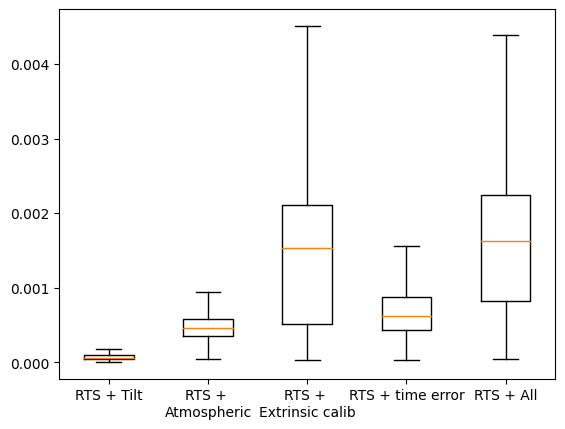

In [11]:
data = Distance_F_total
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + time error', 'RTS + All'])
#ax.set_xticklabels(['RTS + \nExtrinsic calib', 'RTS + All'])
plt.show()

In [12]:
theodo_g = importlib.reload(theodo_g)

## Sort results according to the range of measurements
Distance_F_total_sorted = []
for i,j in zip(Distance_F_total, Parameter_RTS_total):
    Dist_0_25 = []
    Dist_25_75 = []
    Dist_75_125 = []
    Dist_125_200 = []
    Dist_200 = []
    for k,l in zip(i,j):
        if 0 <= l < 25:                 # Between 0 and 25m
            Dist_0_25.append(k*1000)
        if 25 <= l < 75:                # Between 25 and 75m
            Dist_25_75.append(k*1000)
        if 75 <= l < 125:               # Between 75 and 125m
            Dist_75_125.append(k*1000)
        if 125 <= l < 200:              # Between 125 and 200m
            Dist_125_200.append(k*1000)
        if 200 <= l:                    # Between 200 and more
            Dist_200.append(k*1000)
    Distance_F_total_sorted.append([Dist_0_25, Dist_25_75, Dist_75_125, Dist_125_200, Dist_200])

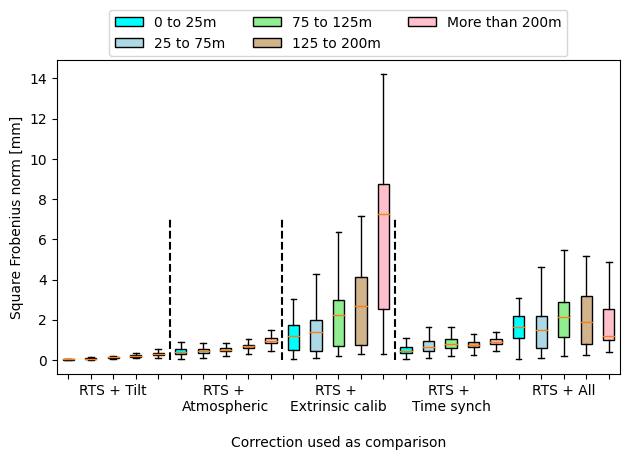

In [13]:
data = []
for i in Distance_F_total_sorted:
    for j in i:
        data.append(j)
max_value = np.max(data[-1])

fig, ax = plt.subplots()
box = ax.boxplot(data, showfliers=False, notch=False, patch_artist=True)
ax.set_xticklabels(['', '', 'RTS + Tilt', '', '',
                    '', '', 'RTS + \nAtmospheric', '', '',
                    '', '', 'RTS + \nExtrinsic calib', '', '',
                    '', '', 'RTS + \nTime synch', '', '',
                    '', '', 'RTS + All', '', '',])

colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink',
          'cyan', 'lightblue', 'lightgreen', 'tan', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.vlines(5.5,0,max_value, linestyles='dashed', color="black")
ax.vlines(10.5,0,max_value, linestyles='dashed', color="black")
ax.vlines(15.5,0,max_value, linestyles='dashed', color="black")

ax.set_xlabel("\nCorrection used as comparison")
ax.set_ylabel("Square Frobenius norm [mm]")
#ax.set_yscale('log')
ax.legend(handles=[box["boxes"][0], box["boxes"][1], box["boxes"][2], box["boxes"][3], box["boxes"][4]],
          labels =['0 to 25m', '25 to 75m', '75 to 125m', '125 to 200m', 'More than 200m'],
          loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)
plt.tight_layout()
#plt.savefig("../figs/uncertainty/Frobenius_norm.png", bbox_inches="tight")
plt.show()

## Check interpolated data

In [ ]:
theodo_u = importlib.reload(theodo_u)
path = "../data/20220307/"
file = "uncertainty/interpolation/MC_Fake_0_0_0_0_0_5"
P1 = theodo_u.read_point_uncertainty_csv_file(path+file+"_1.csv")
P2 = theodo_u.read_point_uncertainty_csv_file(path+file+"_2.csv")
P3 = theodo_u.read_point_uncertainty_csv_file(path+file+"_3.csv")
file = "uncertainty/interpolation/MC_Fake_0_0_0_1_0_5"
P11 = theodo_u.read_point_uncertainty_csv_file(path+file+"_1.csv")
P22 = theodo_u.read_point_uncertainty_csv_file(path+file+"_2.csv")
P33 = theodo_u.read_point_uncertainty_csv_file(path+file+"_3.csv")

In [ ]:
%matplotlib notebook
plt.figure()
for i in P1:
    if (np.trace(i[2][0:2,0:2])/2)**0.5<0.05:
        theodo_g.plot_ellipse(plt.gca(), i[1][0:2], i[2][0:2,0:2], n_std=1, color="red")
        plt.scatter(i[1][0],i[1][1], color='r', s=2)
for i in P2:
    if (np.trace(i[2][0:2,0:2])/2)**0.5<0.05:
        theodo_g.plot_ellipse(plt.gca(), i[1][0:2], i[2][0:2,0:2], n_std=1, color="green")
        plt.scatter(i[1][0],i[1][1], color='green', s=2)
for i in P3:
    if (np.trace(i[2][0:2,0:2])/2)**0.5<0.05:
        theodo_g.plot_ellipse(plt.gca(), i[1][0:2], i[2][0:2,0:2], n_std=1, color="green")
        plt.scatter(i[1][0],i[1][1], color='blue', s=2)
plt.show()

In [ ]:
theodo_u = importlib.reload(theodo_u)

path_vtk = "/home/maxime/data/vtk_traj/"
sigma_plot = 10
# theodo_u.save_to_VTK_uncertainty(sigma_plot, P1, path_vtk + "Prisme_1.vtk", 0.05)
theodo_u.save_to_VTK_uncertainty(sigma_plot, P11, path_vtk + "Prisme_11.vtk", 0.05)
# theodo_u.save_to_VTK_uncertainty(sigma_plot, P2, path_vtk + "Prisme_2.vtk", 0.05)
# theodo_u.save_to_VTK_uncertainty(sigma_plot, P3, path_vtk + "Prisme_3.vtk", 0.05)
#theodo_u.save_to_VTK_uncertainty(sigma_plot, Pose_sensor_MC, path_vtk + "Sensor.vtk")
print("Done !")